# Forest Fires - damaged area estimation

`Original approach in modeling by Cortez and Morias, 2007:`

source: http://archive.ics.uci.edu/ml/datasets/Forest+Fires

In the original paper the output 'area' was first transformed with a ln(x+1) function.
Then, several Data Mining methods were applied. After fitting the models, the outputs were
post-processed with the inverse of the ln(x+1) transform. Four different input setups were
used. The experiments were conducted using a 10-fold (cross-validation) x 30 runs. Two
regression metrics were measured: MAD and RMSE. A Gaussian support vector machine (SVM) fed
with only 4 direct weather conditions (temp, RH, wind and rain) obtained the best MAD value:
12.71 +- 0.01 (mean and confidence interval within 95% using a t-student distribution). The
best RMSE was attained by the naive mean predictor. An analysis to the regression error curve
(REC) shows that the SVM model predicts more examples within a lower admitted error. In effect,
the SVM model predicts better small fires, which are the majority.

`Attribute information:`

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: 'jan' to 'dec'
4. day - day of the week: 'mon' to 'sun'
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20: 
   - The Fine Fuel Moisture Code (FFMC) is a numeric rating of the moisture content of litter and other cured fine fuels. This code is an indicator of the relative ease of ignition and the flammability of fine fuel.
6. DMC - DMC index from the FWI system: 1.1 to 291.3
   - The Duff Moisture Code (DMC) is a numeric rating of the average moisture content of loosely compacted organic layers of moderate depth. This code gives an indication of fuel consumption in moderate duff layers and medium-size woody material.
7. DC - DC index from the FWI system: 7.9 to 860.6
   - The Drought Code (DC) is a numeric rating of the average moisture content of deep, compact organic layers. This code is a useful indicator of seasonal drought effects on forest fuels and the amount of smoldering in deep duff layers and large logs.
8. ISI - ISI index from the FWI system: 0.0 to 56.10
   - The Initial Spread Index (ISI) is a numeric rating of the expected rate of fire spread. It is based on wind speed and FFMC. Like the rest of the FWI system components, ISI does not take fuel type into account. Actual spread rates vary between fuel types at the same ISI.
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40
12. rain - outside rain in mm/m2 : 0.0 to 6.4
13. <b>area - the burned area of the forest (in ha): 0.00 to 1090.84</b>: target variable to predict

<span style="font-family: Arial; font-weight:bold;font-size:1.3em;color:#00b3e5;">  Structure of the FWI (Fire Weather Index) System
<br></span>
![alt text](fwi_structure.png "Fire Weather Index Structure")
source: https://cwfis.cfs.nrcan.gc.ca/background/summary/fwi


## Steps:

 - Data loading and preprocessing
 - Exploratory Data Analysis, uni/bi-variate analysis
 - Feature Engineering
 - Model Selection and cross-validation
 - Model Tuning (grid and randomized searches)

# Data loading and preprocessing

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score

In [2]:
df = pd.read_csv("forestfires.csv")  # Read the data regarding dataset attributes
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [3]:
print(df.shape)

(517, 13)


In [4]:
df.isna().sum()

X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64

In [5]:
df.duplicated().sum()

4

In [6]:
print('Percent of duplicated entries is: ', df.duplicated().sum()/len(df)*100)

Percent of duplicated entries is:  0.7736943907156674


In [7]:
dupies=df[df.duplicated()]
dupies

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
53,4,3,aug,wed,92.1,111.2,654.1,9.6,20.4,42,4.9,0.0,0.00
100,3,4,aug,sun,91.4,142.4,601.4,10.6,19.8,39,5.4,0.0,0.00
215,4,4,mar,sat,91.7,35.8,80.8,7.8,17.0,27,4.9,0.0,28.66
303,3,6,jun,fri,91.1,94.1,232.1,7.1,19.2,38,4.5,0.0,0.00


`Considered as duplicated just because of one of values as the same as previous rows, when other values are different. So that not all of them are duplicated rows. Checking unique values`

In [8]:
dupies.nunique()

X        2
Y        3
month    3
day      4
FFMC     4
DMC      4
DC       4
ISI      4
temp     4
RH       4
wind     3
rain     1
area     2
dtype: int64

`Not realy duplicated, 4 unique values for most critical variables, should not be removed.`

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
X,517.0,4.669246,2.313778,1.0,3.0,4.00,7.00,9.00
Y,517.0,4.299807,1.229900,2.0,4.0,4.00,5.00,9.00
FFMC,517.0,90.644681,5.520111,18.7,90.2,91.60,92.90,96.20
DMC,517.0,110.872340,64.046482,1.1,68.6,108.30,142.40,291.30
DC,517.0,547.940039,248.066192,7.9,437.7,664.20,713.90,860.60
ISI,517.0,9.021663,4.559477,0.0,6.5,8.40,10.80,56.10
temp,517.0,18.889168,5.806625,2.2,15.5,19.30,22.80,33.30
RH,517.0,44.288201,16.317469,15.0,33.0,42.00,53.00,100.00
wind,517.0,4.017602,1.791653,0.4,2.7,4.00,4.90,9.40
rain,517.0,0.021663,0.295959,0.0,0.0,0.00,0.00,6.40


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [11]:
df.nunique()

X          9
Y          7
month     12
day        7
FFMC     106
DMC      215
DC       219
ISI      119
temp     192
RH        75
wind      21
rain       7
area     251
dtype: int64

In [12]:
df.skew()

X        0.036246
Y        0.417296
FFMC    -6.575606
DMC      0.547498
DC      -1.100445
ISI      2.536325
temp    -0.331172
RH       0.862904
wind     0.571001
rain    19.816344
area    12.846934
dtype: float64

In [13]:
df['area'].value_counts(normalize=True)*100

0.00     47.775629
1.94      0.580271
3.71      0.386847
0.90      0.386847
1.95      0.386847
           ...    
1.26      0.193424
2.44      0.193424
2.03      0.193424
2.21      0.193424
24.24     0.193424
Name: area, Length: 251, dtype: float64

### Insights:

 - Data length is about 1000 entries, with 2.5% duplicates
 - Without NaN, negative or 'character' values, all are numeric (float or int)
 - Columns slag, ash, superplastic contain many zeros and non-normally distributed
 - age is skewed to the left
 - Output variable, strength, has the highest number of unique values

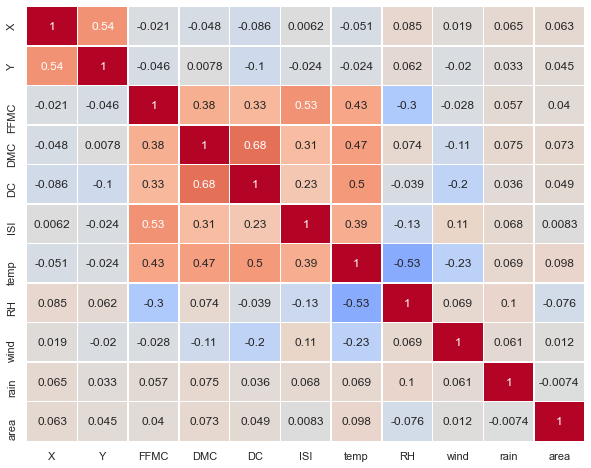

In [14]:
# Correlations heat map

sns.set(rc={'figure.figsize':(10,8)})
sns.heatmap(df.corr(),
            annot=True,
            linewidths=0.5,
            center=0,
            cbar=False,
            cmap="coolwarm")
plt.show()

### Insights:

 - superplastic correlates with water with a negative factor of -0.66 (the highest value).
 - slag, ash and superplastic have many zero values and non-normally ditributed. These attributes should be 'engineered' in a way to allow good predictors scores. 
 - Strength (output variable) positevely correlates with cement, age and superplastic, negatively with water.

<AxesSubplot:>

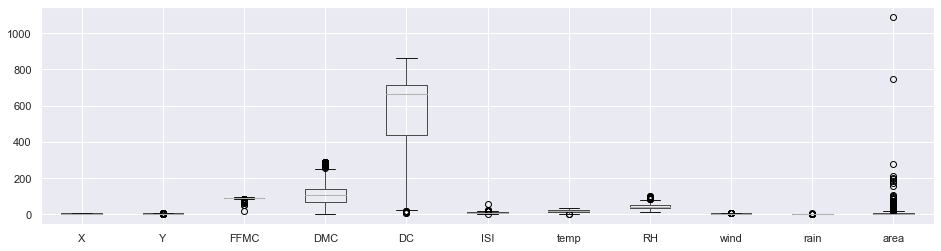

In [15]:
df.boxplot(figsize=(16,4))

<AxesSubplot:xlabel='area', ylabel='Count'>

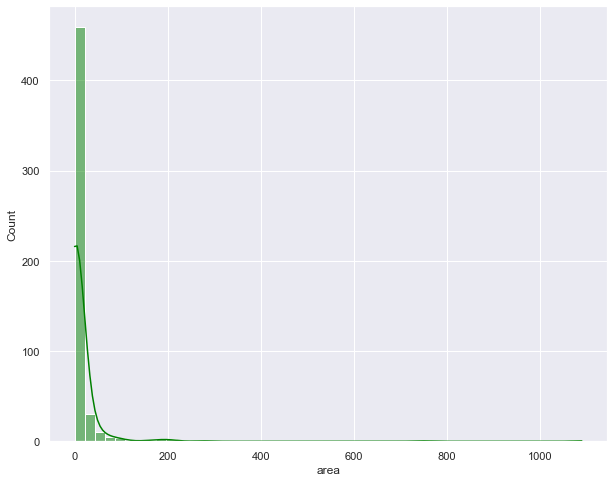

In [17]:
sns.histplot(df['area'], kde=True, bins=50, color='green')

### Insights:

 - cement, water, coarseagg, fineagg and strength look normally distributed, although water and strength have some outliers
 - slag, ash, superplastic are non-normally ditributed due to multiple zeros.
 - age should be log-transformed.

In [18]:
df['fire_yes_no']=df['area'].apply(lambda x: 1 if x>0 else 0)

/Users/innag/opt/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


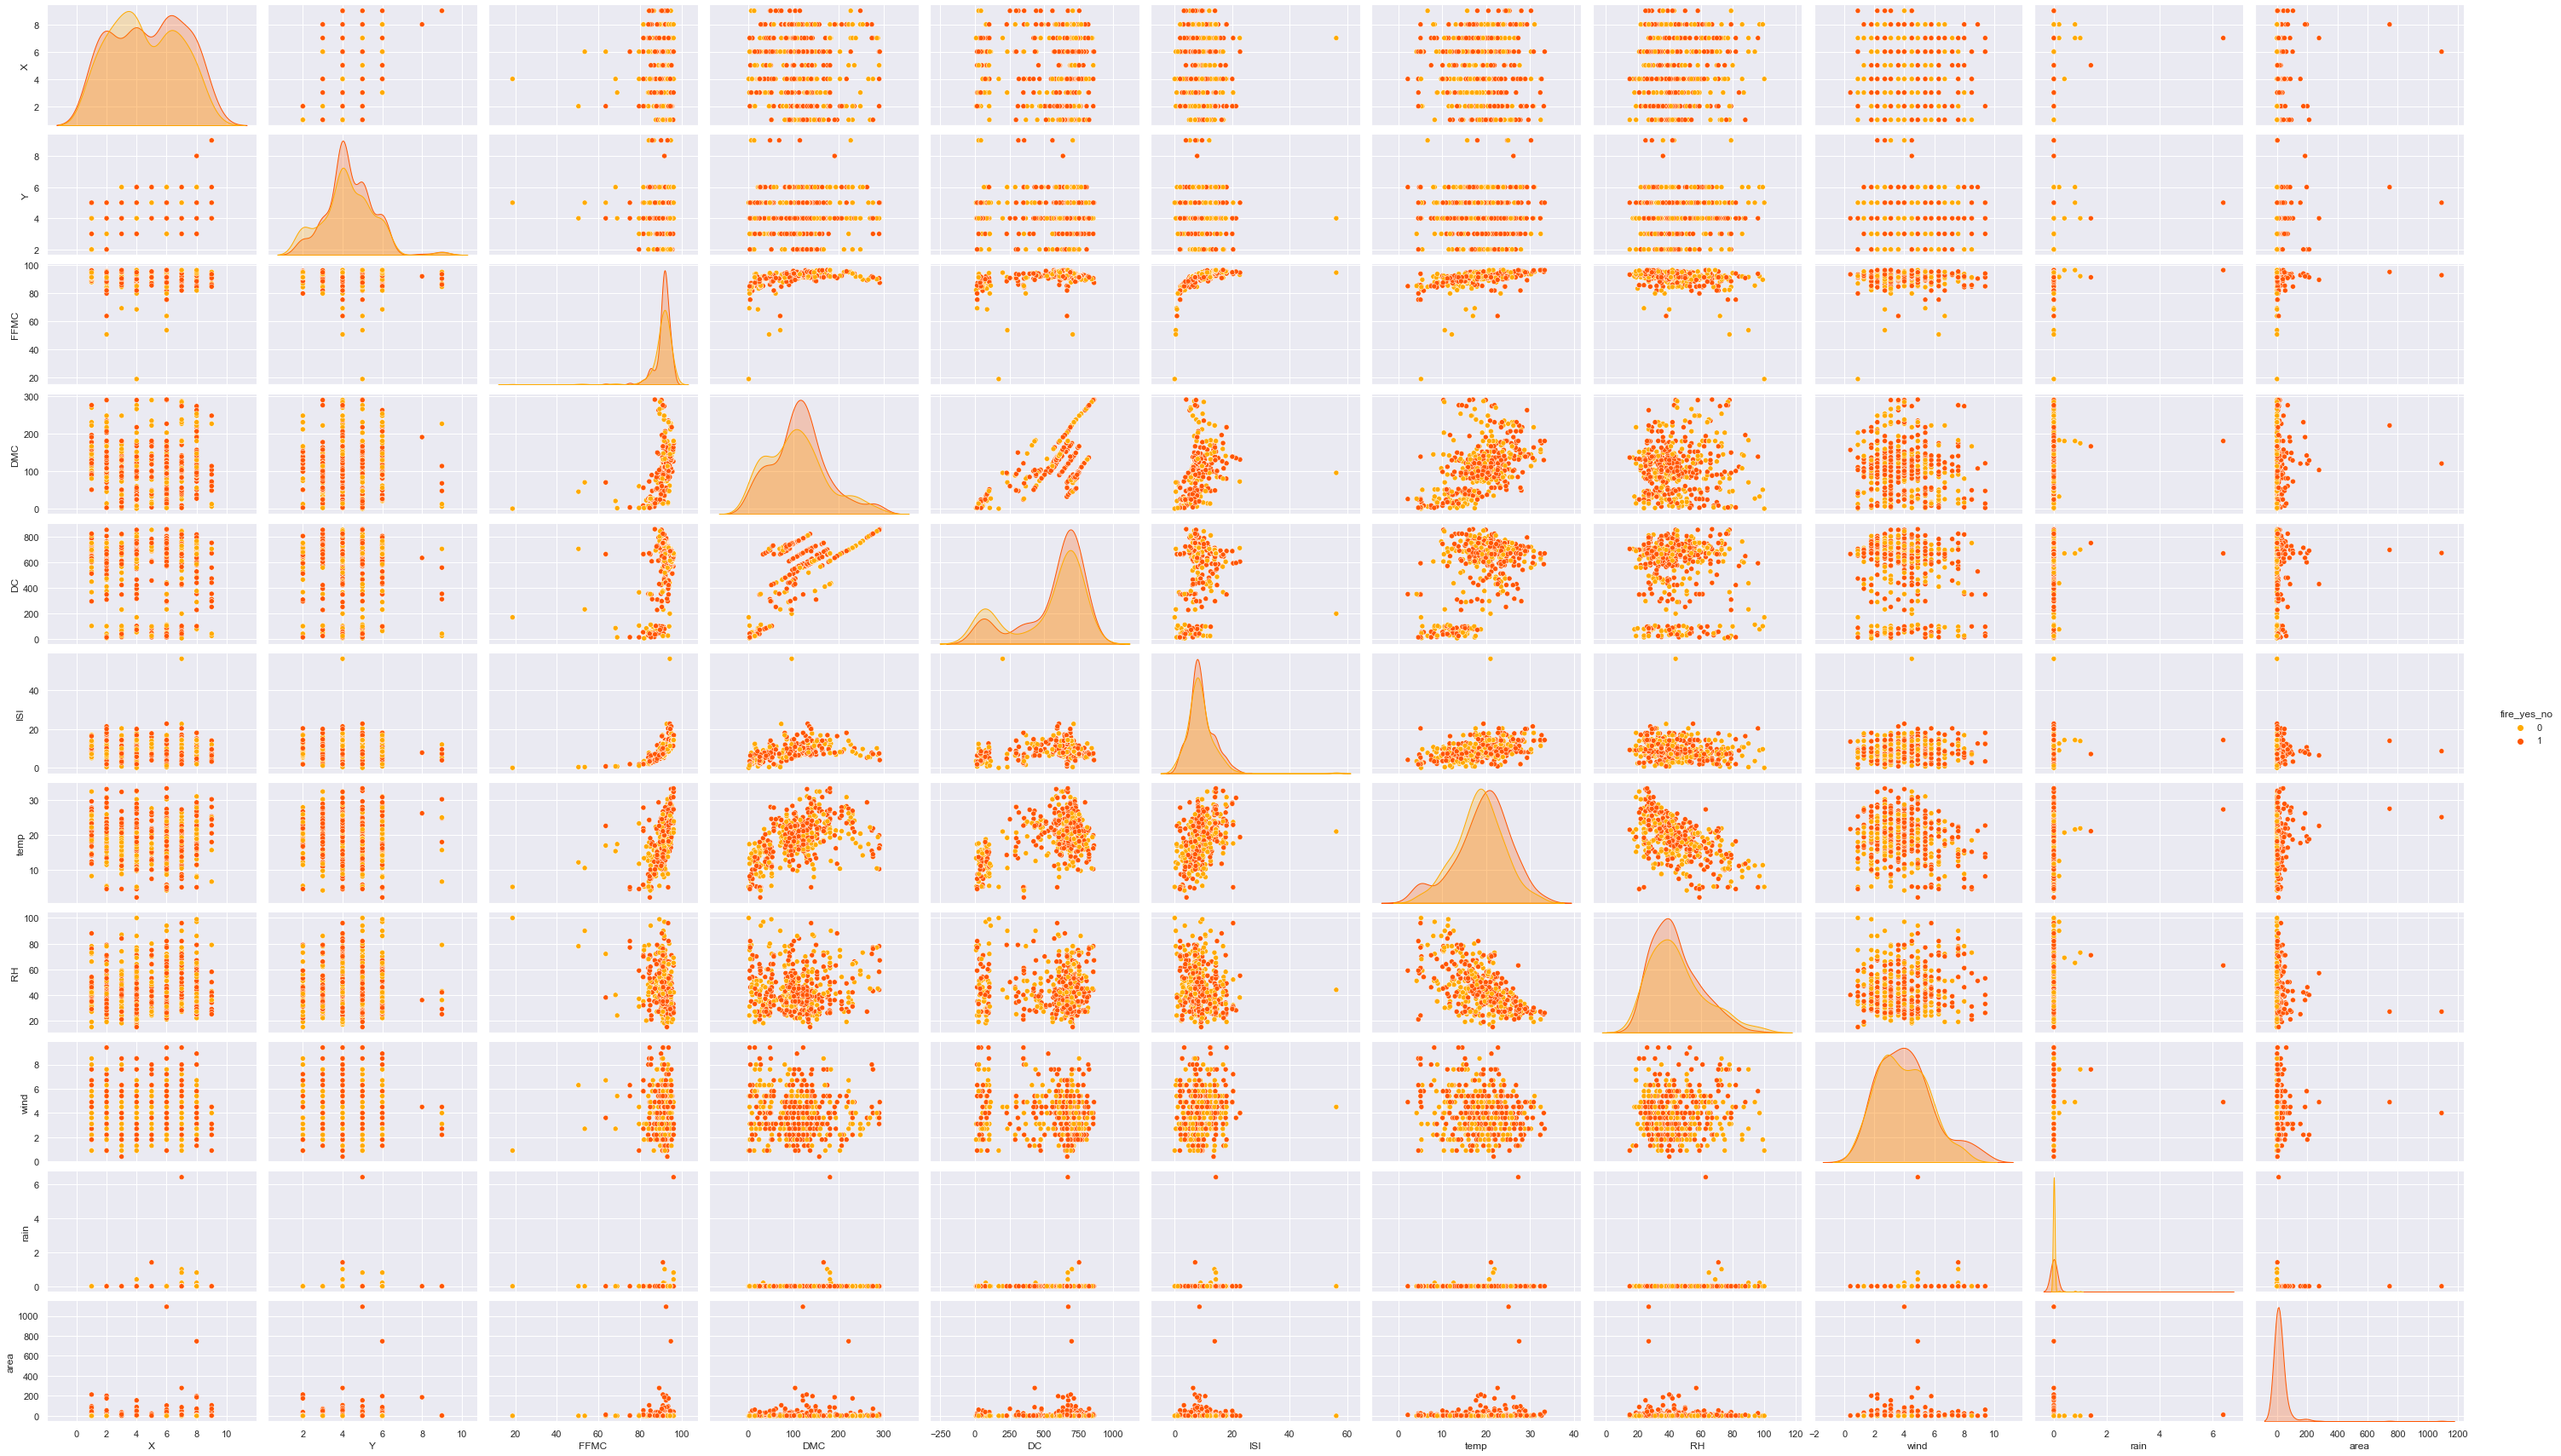

In [19]:
sns.pairplot(df, hue='fire_yes_no', height=2.2, aspect=1.7, palette='autumn_r')

In [20]:
df['fire_yes_no'].value_counts(normalize=True)*100

1    52.224371
0    47.775629
Name: fire_yes_no, dtype: float64

In [21]:
yes_fire=df.loc[df['area'] > 0]
no_fire=df.loc[df['area'] == 0]

print('data lengths with and without fired areas are: ', len(yes_fire), len(no_fire))

data lengths with and without fired areas are:  270 247


### Classification --> regression modeling approach:
1. Find fire: yes or no? binary classificarion (using entire dataset of 517 rows)
2. If fire == yes, calculate its' area (about 52% from given dataset), else zero

<AxesSubplot:xlabel='area', ylabel='Count'>

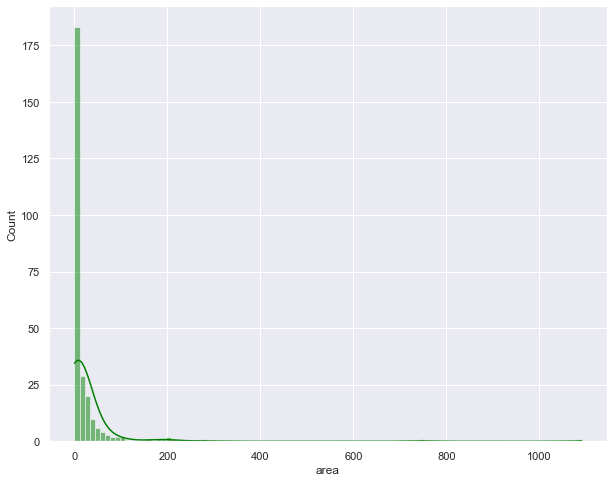

In [22]:
sns.histplot(yes_fire['area'], kde=True, bins=100, color='green')

In [23]:
yes_fire['area'].value_counts()

1.94     3
0.68     2
1.64     2
28.66    2
2.18     2
        ..
0.77     1
11.19    1
20.03    1
1.58     1
6.83     1
Name: area, Length: 250, dtype: int64

In [24]:
df.groupby('fire_yes_no').median()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
fire_yes_no,,,,,,,,,,,
0,4,4,91.6,103.2,661.3,8.4,18.6,42,3.6,0.0,0.00
1,5,4,91.7,111.7,665.6,8.4,20.1,41,4.0,0.0,6.37


In [25]:
df.groupby('fire_yes_no').max()



,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
fire_yes_no,,,,,,,,,,,,,
0,9,9,sep,wed,96.2,290.0,855.3,56.1,32.4,100,8.5,1.0,0.00
1,9,9,sep,wed,96.2,291.3,860.6,22.7,33.3,96,9.4,6.4,1090.84


<AxesSubplot:xlabel='month', ylabel='count'>

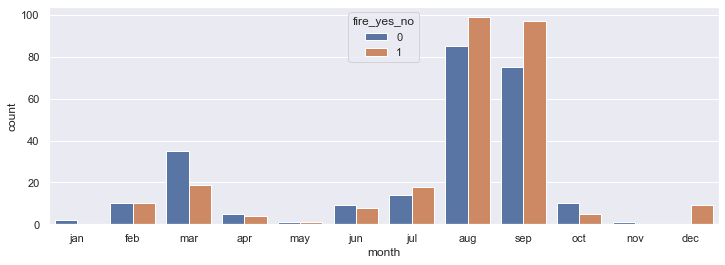

In [39]:
month=['jan', 'feb', 'mar', 'apr', 'may','jun', 'jul', 'aug','sep','oct', 'nov','dec']
sns.set(rc={'figure.figsize':(12,4)})
sns.countplot(data=df,x='month', order=month, hue='fire_yes_no')

<AxesSubplot:xlabel='day', ylabel='count'>

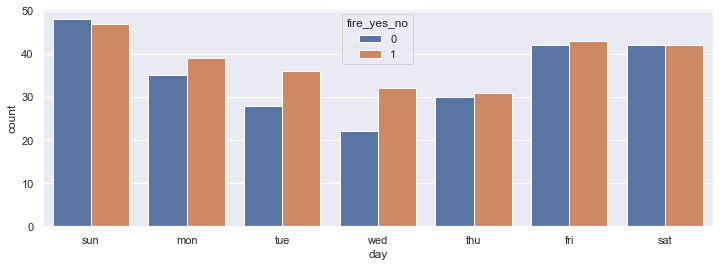

In [40]:
day=['sun', 'mon', 'tue', 'wed', 'thu','fri', 'sat']
sns.set(rc={'figure.figsize':(12,4)})
sns.countplot(data=df,x='day', order=day, hue='fire_yes_no')

`45, 55 and 37% zero values for slag, ash and superplastic respectively. This attributes need to be engineered or transformed.`

### Insights & Preprocessing Steps. 

 - since water and superplastic are correlating negatively, they can be engineered into 'stack' attributes with a certain relation (such as ratio, percent, sum, etc.)
 - slag and ash both having > 40% zeros, and can be also engineered into 'stack' attributes in attempt to mitigate non-normality.
 - age will be log transformed.

### EDA: Uni / Multivariate Analysis

<AxesSubplot:>

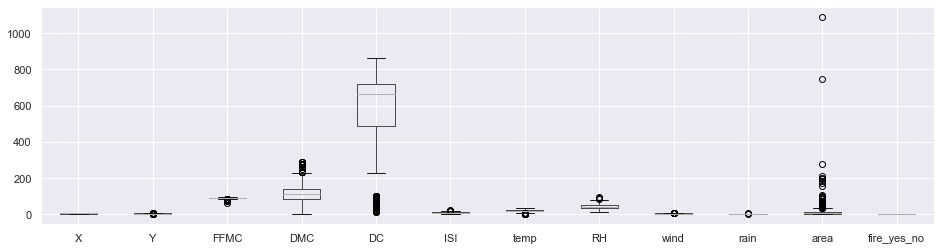

In [41]:
yes_fire.boxplot(figsize=(16,4))

<AxesSubplot:>

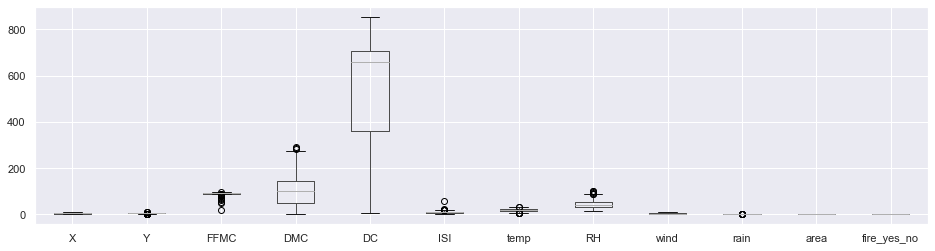

In [42]:
no_fire.boxplot(figsize=(16,4))

In [43]:
yes_fire.describe().T

,count,mean,std,min,25%,50%,75%,max
X,270.0,4.807407,2.383326,1.00,3.000,5.00,7.0000,9.00
Y,270.0,4.366667,1.170740,2.00,4.000,4.00,5.0000,9.00
FFMC,270.0,91.034074,3.709020,63.50,90.325,91.70,92.9750,96.20
DMC,270.0,114.707778,61.786520,3.20,82.900,111.70,141.3000,291.30
DC,270.0,570.867037,229.981242,15.30,486.500,665.60,721.3250,860.60
ISI,270.0,9.177037,4.147350,0.80,6.800,8.40,11.3750,22.70
temp,270.0,19.311111,6.179444,2.20,16.125,20.10,23.4000,33.30
RH,270.0,43.733333,15.080059,15.00,33.000,41.00,53.0000,96.00
wind,270.0,4.112963,1.884573,0.40,2.700,4.00,4.9000,9.40
rain,270.0,0.028889,0.398392,0.00,0.000,0.00,0.0000,6.40


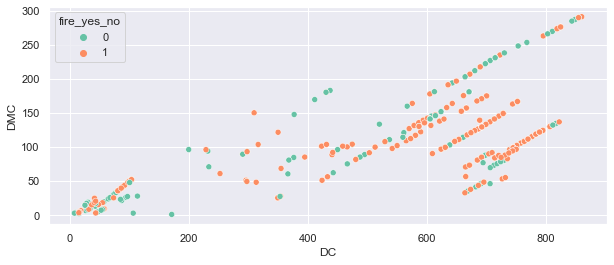

In [44]:
plt.rcParams['figure.figsize'] = (10, 4)
sns.scatterplot(x=df['DC'], y=df['DMC'], hue=df['fire_yes_no'], palette='Set2') 
plt.show()

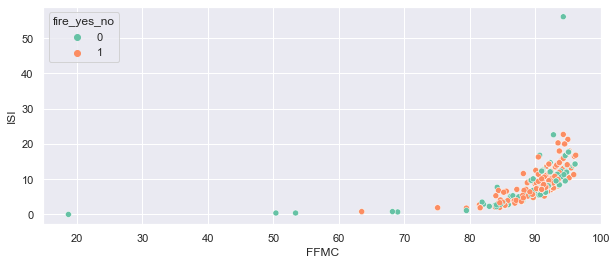

In [45]:
plt.rcParams['figure.figsize'] = (10, 4)
sns.scatterplot(x=df['FFMC'], y=df['ISI'], hue=df['fire_yes_no'], palette='Set2') 
plt.show()

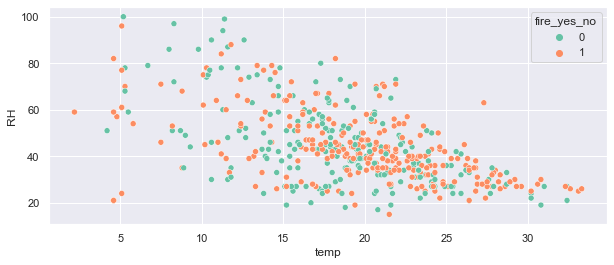

In [46]:
plt.rcParams['figure.figsize'] = (10, 4)
sns.scatterplot(x=df['temp'], y=df['RH'], hue=df['fire_yes_no'], palette='Set2') 
plt.show()

### Insights:

- Isolation from zeros revealed almost normally distrubuted values in slag, ash and superplastic, which in total with zeros looks almost as double mixed ditributions. Linear Regression models can result in lower scores, where Tree / Forest regressors can be better approach.
- No correlation between slag and ash, when isolated from zeros.

### Feature Engineering

 - X and Y replace by sqrt(X^2+Y^2)
 - DMC / (DMC + DC): they are similar and correlating

In [47]:
df1=df.copy()

features_fl=['area', 'FFMC', 'ISI']

for i in features_fl:
                        
    df1[i+'_log']=np.log1p(df1[i])
    df1.drop(i, axis=1, inplace=True)
    
#sns.pairplot(df1, hue='fire_yes_no', height=3, aspect=1.7, palette='autumn_r')

In [50]:
df1['area_log'].value_counts(normalize=True)

0.000000    0.477756
1.078410    0.005803
0.970779    0.003868
0.418710    0.003868
0.641854    0.003868
              ...   
1.064711    0.001934
5.049086    0.001934
3.242202    0.001934
0.959350    0.001934
2.166765    0.001934
Name: area_log, Length: 251, dtype: float64

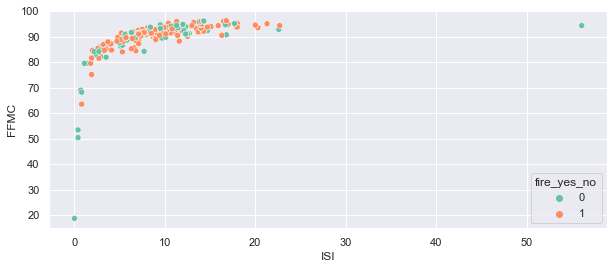

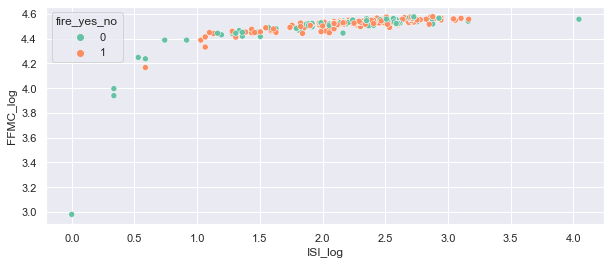

log correlation between ISI and FFMC is:  0.6433895940893903


In [51]:
plt.rcParams['figure.figsize'] = (10, 4)
sns.scatterplot(x=df['ISI'], y=df['FFMC'], hue=df['fire_yes_no'], palette='Set2') 
plt.show()
plt.rcParams['figure.figsize'] = (10, 4)
sns.scatterplot(x=df1['ISI_log'], y=df1['FFMC_log'], hue=df1['fire_yes_no'], palette='Set2') 
plt.show()

print('log correlation between ISI and FFMC is: ', df1['FFMC_log'].corr(df1['ISI_log']))

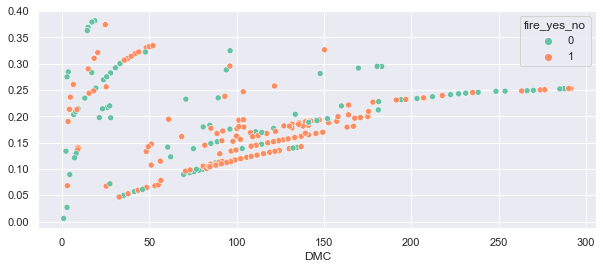

In [52]:
plt.rcParams['figure.figsize'] = (10, 4)
sns.scatterplot(x=df1['DMC'], y=df1['DMC']/(df1['DMC']+df1['DC']), hue=df1['fire_yes_no'], palette='Set2') 
plt.show()

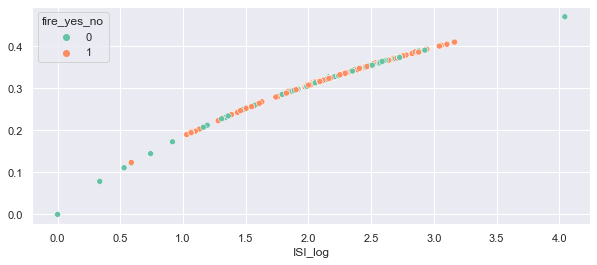

In [53]:
plt.rcParams['figure.figsize'] = (10, 4)
sns.scatterplot(x=df1['ISI_log'], y=df1['ISI_log']/(df1['ISI_log']+df1['FFMC_log']), hue=df1['fire_yes_no'], palette='Set2') 
plt.show()

### Approach:

 - X and Y replace by sqrt(X^2+Y^2)
 - DMC + DC: convert to ratio
 - ISI and FFMC to log, then convert to ratio
 - Perform Label Encoding to save number of input columns for month and day

In [54]:
df2=df1.copy()

df2['Z']=np.sqrt(df2['X']*df2['X']+df2['Y']*df2['Y'])

df2['DMC_DC_ratio'] = df2['DMC']/(df2['DMC']+df2['DC'])

df2['ISI_FFMC_log_ratio']=df2['ISI_log']/(df2['ISI_log']+df2['FFMC_log'])

In [55]:
cols_to_drop=['X', 'Y', 'DMC', 'DC', 'ISI_log', 'FFMC_log']

df2.drop(cols_to_drop, axis=1, inplace=True)

df2.describe().T

,count,mean,std,min,25%,50%,75%,max
temp,517.0,18.889168,5.806625,2.200000,15.500000,19.300000,22.800000,33.300000
RH,517.0,44.288201,16.317469,15.000000,33.000000,42.000000,53.000000,100.000000
wind,517.0,4.017602,1.791653,0.400000,2.700000,4.000000,4.900000,9.400000
rain,517.0,0.021663,0.295959,0.000000,0.000000,0.000000,0.000000,6.400000
fire_yes_no,517.0,0.522244,0.499989,0.000000,0.000000,1.000000,1.000000,1.000000
area_log,517.0,1.111026,1.398436,0.000000,0.000000,0.418710,2.024193,6.995620
Z,517.0,6.498661,2.218121,2.236068,5.000000,6.403124,8.062258,12.727922
DMC_DC_ratio,517.0,0.181691,0.071960,0.006377,0.131856,0.169632,0.234182,0.381818
ISI_FFMC_log_ratio,517.0,0.323960,0.051331,0.000000,0.307787,0.330231,0.352034,0.470226


### Insights:

 - 'slag_ash_perc' separated into three major distributions - it can be replaced by a categorical variable.
 - 'sum_water_sp' is almost normally distributed.
 - double ditributaion remained in 'sum_of_solids' and 'superplastic_water_perc'.

<AxesSubplot:>

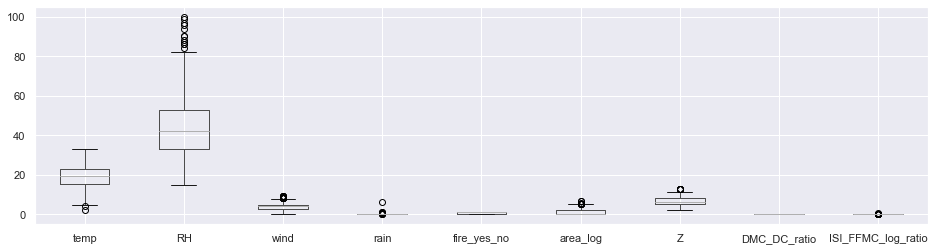

In [57]:
df2.boxplot(figsize=(16,4))

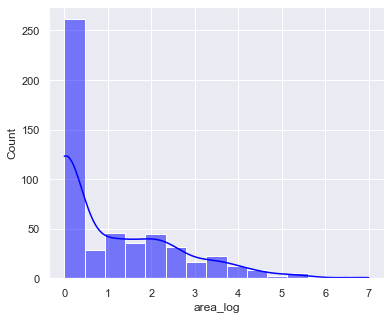

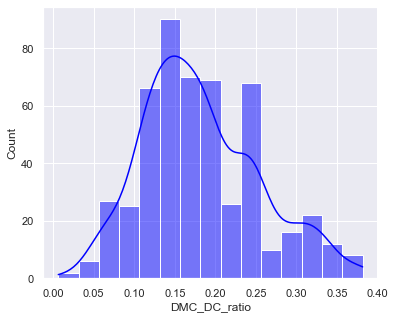

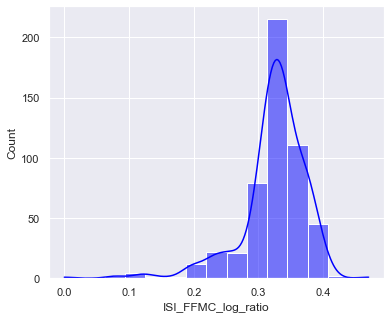

In [58]:
features=['area_log', 'DMC_DC_ratio', 'ISI_FFMC_log_ratio']

for i in features:
    
    sns.set(rc={'figure.figsize':(6,5)})
    sns.histplot(df2[i], kde=True, bins=15, color='blue')
    plt.show()

### Insights:
 - Strongest correlations for the output variable, strength, with:
   - superplastic_water_perc
   - age
   - cement
 - Negative correlation with
   - sum_water_sp
   
`Overall correlation scores are similar, when there are no major strong correlations between the independent variables. Engineered features partially helped to mitigate the non-normality (conversion to categorical).`

 - 'slag_ash_percent' manual encoding into three major categories.

In [87]:
# for i in list(df3.columns[df3.dtypes=='object']): 
    
#     df3[i]=df3[i].astype(int)

# df3.info()

In [59]:
Q1 = df2.quantile(q=0.25)
Q3 = df2.quantile(q=0.75)
IQR = Q3 - Q1
IQR

temp                   7.300000
RH                    20.000000
wind                   2.200000
rain                   0.000000
fire_yes_no            1.000000
area_log               2.024193
Z                      3.062258
DMC_DC_ratio           0.102326
ISI_FFMC_log_ratio     0.044247
dtype: float64

In [60]:
outliers = np.where((df2 < (Q1 - 1.5 * IQR)) | (df2 > (Q3 + 1.5 * IQR)))

print('% outliers in dataset is: ', round(len(outliers[0])/len(df2)*100, 1))

% outliers in dataset is:  16.8


### Insights:

 - Amount of outliers is only 6%. Not removing them because:
   - the dataset is relativelly small, so that it may bias the original data
   - it can decrease the model scores
   - there are non-normally distributed features in any case, so that Linear Regression likely is not the best option here, where Tree Regressors are not much sensitive to the outliers 

## Data Split and Scaling

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [62]:
print(df2.shape)

(517, 11)


In [63]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   month               517 non-null    object 
 1   day                 517 non-null    object 
 2   temp                517 non-null    float64
 3   RH                  517 non-null    int64  
 4   wind                517 non-null    float64
 5   rain                517 non-null    float64
 6   fire_yes_no         517 non-null    int64  
 7   area_log            517 non-null    float64
 8   Z                   517 non-null    float64
 9   DMC_DC_ratio        517 non-null    float64
 10  ISI_FFMC_log_ratio  517 non-null    float64
dtypes: float64(7), int64(2), object(2)
memory usage: 44.6+ KB


### Label Encoding

In [64]:
print(f'for day {df2.day.value_counts(normalize=True)}, and for month {df2.month.value_counts(normalize=True)}')

for day sun    0.183752
fri    0.164410
sat    0.162476
mon    0.143133
tue    0.123791
thu    0.117988
wed    0.104449
Name: day, dtype: float64, and for month aug    0.355899
sep    0.332689
mar    0.104449
jul    0.061896
feb    0.038685
jun    0.032882
oct    0.029014
apr    0.017408
dec    0.017408
jan    0.003868
may    0.003868
nov    0.001934
Name: month, dtype: float64


In [65]:
from sklearn.preprocessing import LabelEncoder   # import label encoder

encoder = LabelEncoder()  

df2['DayId'] = encoder.fit_transform(df2.day) # returns label encoded variable(s)
df2['MonthId'] = encoder.fit_transform(df2.month) 

df2.head()

,month,day,temp,RH,wind,rain,fire_yes_no,area_log,Z,DMC_DC_ratio,ISI_FFMC_log_ratio,DayId,MonthId
0,mar,fri,8.2,51,6.7,0.0,0,0.0,8.602325,0.217427,0.288105,0,7
1,oct,tue,18.0,33,0.9,0.0,0,0.0,8.062258,0.050248,0.311226,5,10
2,oct,sat,14.6,33,1.3,0.0,0,0.0,8.062258,0.059814,0.311226,2,10
3,mar,fri,8.3,97,4.0,0.2,0,0.0,10.000000,0.300542,0.337032,0,7
4,mar,sun,11.4,99,1.8,0.0,0,0.0,10.000000,0.334202,0.343948,3,7


In [66]:
print(f'for day {df2.DayId.value_counts(normalize=True)}, and for month {df2.MonthId.value_counts(normalize=True)}')

for day 3    0.183752
0    0.164410
2    0.162476
1    0.143133
5    0.123791
4    0.117988
6    0.104449
Name: DayId, dtype: float64, and for month 1     0.355899
11    0.332689
7     0.104449
5     0.061896
3     0.038685
6     0.032882
10    0.029014
2     0.017408
0     0.017408
8     0.003868
4     0.003868
9     0.001934
Name: MonthId, dtype: float64


In [67]:
df3=df2.drop(['day', 'month'], axis=1)

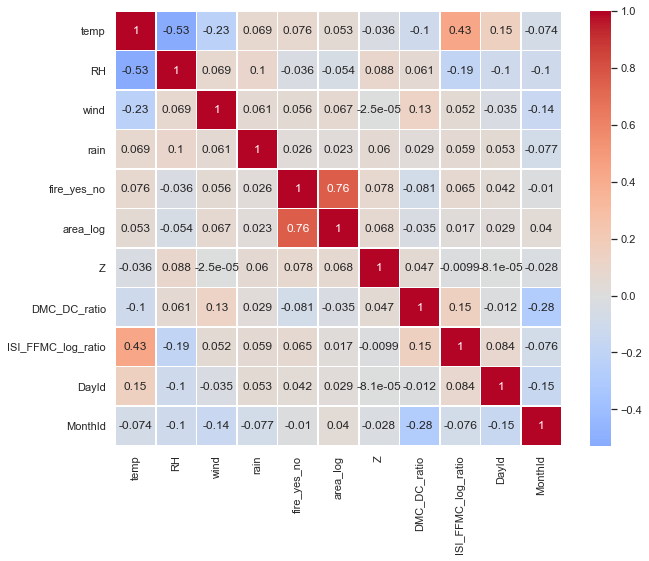

In [72]:
sns.set(rc={'figure.figsize':(10,8)})
sns.heatmap(df3.corr(),
            annot=True,
            linewidths=0.5,
            center=0,
            cbar=True,
            cmap="coolwarm")
plt.show()

In [246]:
#sns.pairplot(df3, hue='fire_yes_no', height=2.2, aspect=1.7, palette='autumn_r')

In [73]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   temp                517 non-null    float64
 1   RH                  517 non-null    int64  
 2   wind                517 non-null    float64
 3   rain                517 non-null    float64
 4   fire_yes_no         517 non-null    int64  
 5   area_log            517 non-null    float64
 6   Z                   517 non-null    float64
 7   DMC_DC_ratio        517 non-null    float64
 8   ISI_FFMC_log_ratio  517 non-null    float64
 9   DayId               517 non-null    int64  
 10  MonthId             517 non-null    int64  
dtypes: float64(7), int64(4)
memory usage: 44.6 KB


In [81]:
df3['fire_yes_no'].value_counts(normalize=True)

1    0.522244
0    0.477756
Name: fire_yes_no, dtype: float64

In [74]:
X = df3.drop(columns=['area_log', 'fire_yes_no'])  # Separating the target and the rest
y = df3.fire_yes_no

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = 177788)

In [90]:
print('train data size', X_train.shape, y_train.shape)
print('test data size', X_test.shape, y_test.shape)

train data size (413, 9) (413,)
test data size (104, 9) (104,)


In [91]:
# y_train1 = y_train.values.reshape(-1,1)
# y_test1 = y_test.values.reshape(-1,1)

# y_train1.shape
print('train distribution', y_train.value_counts(normalize=True))
print('test distribution', y_test.value_counts(normalize=True))

train distribution 1    0.523002
0    0.476998
Name: fire_yes_no, dtype: float64
test distribution 1    0.519231
0    0.480769
Name: fire_yes_no, dtype: float64


In [80]:
from sklearn.preprocessing import MinMaxScaler

In [92]:
X_scaler = MinMaxScaler().fit(X_train)
#y_scaler = MinMaxScaler().fit(y_train1)
X_train_scaled = X_scaler.transform(X_train)

In [93]:
X_test_scaled = X_scaler.transform(X_test)
#y_test_scaled = y_scaler.transform(y_test1)

In [94]:
X_scaled = X_scaler.transform(X)
#y_scaled = y_scaler.transform(y.values.reshape(-1,1))

In [95]:
X_train_scaled[0]

array([0.67845659, 0.22352941, 0.3       , 0.        , 0.47418069,
       0.63056973, 0.76533694, 0.        , 0.09090909])

## 1. Classification Model:  Fire --> Yes / No

### Logistic Regression

In [87]:
from sklearn.linear_model import LogisticRegression
from scipy.stats import randint as sp_randint

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, classification_report, roc_auc_score,accuracy_score

In [109]:
#from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score,accuracy_score

logreg = LogisticRegression(
    random_state=856788, 
    fit_intercept=True, 
    solver='liblinear',  
    class_weight={0:0.4, 1:0.6}, 
    max_iter=1000)

logreg.fit(X_train, y_train)

LogisticRegression(class_weight={0: 0.4, 1: 0.6}, max_iter=1000,
                   random_state=856788, solver='liblinear')

In [110]:
# Predict test data
y_pred_lr = logreg.predict(X_test)

In [111]:
print("Testing accuracies: ",round(logreg.score(X_test, y_test),3))
print()
print("Recalls: ", round(recall_score(y_test, y_pred_lr),3))
print()
print("F1 Scores: ", round(f1_score(y_test, y_pred_lr),3))

Testing accuracies:  0.519

Recalls:  0.981

F1 Scores:  0.679


In [115]:
y_test.value_counts()

1    54
0    50
Name: fire_yes_no, dtype: int64

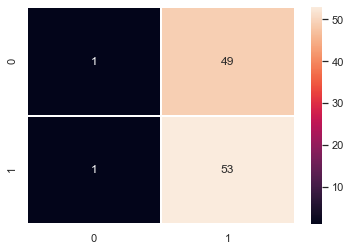

In [114]:
cf_matrix = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize = (6,4))
sns.heatmap(cf_matrix, linewidths=1, annot=True, fmt='g')
plt.show()

### Decision Tree

In [121]:
model_dt = DecisionTreeClassifier(random_state=88327)

In [122]:
model_dt.get_params().keys()

dict_keys(['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'presort', 'random_state', 'splitter'])

In [119]:
#DecisionTreeClassifier?

In [148]:
params={'criterion':['gini','entropy'],
        'splitter':['best', 'random'],
        'max_depth': [3, 5, 7, 9],
        'class_weight': [{0:0.3, 1:0.7}, {0:0.35, 1:0.65}, {0:0.4, 1:0.6}, {0:0.5, 1:0.5}],
        'min_impurity_decrease':[0.0001, 0.001]
}

In [149]:
#GridSearchCV?

In [150]:
grid = GridSearchCV(model_dt, params, scoring='accuracy', cv=3, verbose=0)
grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

{'class_weight': {0: 0.4, 1: 0.6}, 'criterion': 'gini', 'max_depth': 5, 'min_impurity_decrease': 0.0001, 'splitter': 'best'}
0.5763426072851653


In [151]:
y_pred_dt = grid.predict(X_test)

print("Testing accuracies: ",round(grid.score(X_test, y_test),3))
print()
print("Recalls: ", round(recall_score(y_test, y_pred_dt),3))
print()
print("F1 Scores: ", round(f1_score(y_test, y_pred_dt),3))

Testing accuracies:  0.548

Recalls:  0.87

F1 Scores:  0.667


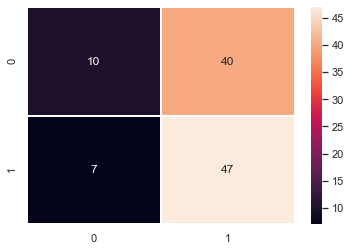

In [152]:
cf_matrix = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize = (6,4))
sns.heatmap(cf_matrix, linewidths=1, annot=True, fmt='g')
plt.show()

### Tree Visualization

In [159]:
from sklearn.tree import export_graphviz  
from six import StringIO
from IPython.display import Image  
import pydotplus
import graphviz

In [167]:
features = [col for col in df3.columns if (col != 'fire_yes_no') & (col !='area_log')]
features

['temp',
 'RH',
 'wind',
 'rain',
 'Z',
 'DMC_DC_ratio',
 'ISI_FFMC_log_ratio',
 'DayId',
 'MonthId']

In [162]:
model_dt_gs = DecisionTreeClassifier(random_state=88327,
                                     criterion='gini', 
                                     class_weight={0: 0.4, 1: 0.6},
                                     max_depth=5,
                                     min_impurity_decrease=0.0001, 
                                     splitter='best')
model_dt_gs.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.4, 1: 0.6}, max_depth=5,
                       min_impurity_decrease=0.0001, random_state=88327)

In [187]:
from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import graphviz

In [191]:
dot_data = StringIO()
export_graphviz(model_dt_gs, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = features, class_names=['No_Fire','Fire'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#graph.write_png('forest_fires_dt.png')
#Image(graph.create_png())

### Ranfom Forest Classifier

In [192]:
from sklearn.ensemble import RandomForestClassifier

In [193]:
rfcl = RandomForestClassifier(random_state=88327)

In [194]:
rfcl.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [195]:
#RandomForestClassifier?

In [196]:
params={'criterion':['gini','entropy'],
        'n_estimators':[50, 100, 200],
        'max_depth': [3, 5, 7, 9],
        'class_weight': [{0:0.3, 1:0.7}, {0:0.35, 1:0.65}, {0:0.4, 1:0.6}, {0:0.5, 1:0.5}],
        'min_impurity_decrease':[0.0001, 0.001],
        'warm_start':[True, False]}

In [198]:
grid = GridSearchCV(rfcl, params, scoring='accuracy', cv=3, verbose=0)
grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

{'class_weight': {0: 0.4, 1: 0.6}, 'criterion': 'gini', 'max_depth': 5, 'min_impurity_decrease': 0.001, 'n_estimators': 100, 'warm_start': True}
0.6077083112944744


In [199]:
y_pred_rf = grid.predict(X_test)

print("Testing accuracies: ",round(grid.score(X_test, y_test),3))
print()
print("Recalls: ", round(recall_score(y_test, y_pred_rf),3))
print()
print("F1 Scores: ", round(f1_score(y_test, y_pred_rf),3))

Testing accuracies:  0.558

Recalls:  0.852

F1 Scores:  0.667


In [200]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.60      0.24      0.34        50
           1       0.55      0.85      0.67        54

    accuracy                           0.56       104
   macro avg       0.57      0.55      0.50       104
weighted avg       0.57      0.56      0.51       104



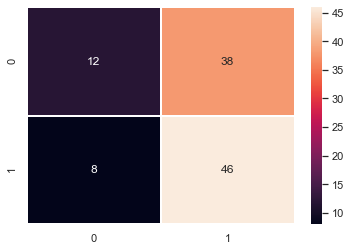

In [201]:
cf_matrix = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize = (6,4))
sns.heatmap(cf_matrix, linewidths=1, annot=True, fmt='g')
plt.show()

### AdaBoost Classifier

In [202]:
from sklearn.ensemble import AdaBoostClassifier

In [203]:
abcl = AdaBoostClassifier(random_state=473)

In [204]:
abcl.get_params().keys()

dict_keys(['algorithm', 'base_estimator', 'learning_rate', 'n_estimators', 'random_state'])

In [205]:
#AdaBoostClassifier?

In [207]:
params={'algorithm':['SAMME', 'SAMME.R'],
        'learning_rate': [0.001, 0.01, 0.1, 0.2],
        'n_estimators':[50, 100, 200]}

In [208]:
grid = GridSearchCV(abcl, params, scoring='accuracy', cv=3, verbose=0)
grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

{'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 50}
0.5932684509326845


In [209]:
y_pred_ab = grid.predict(X_test)

print("Testing accuracies: ",round(grid.score(X_test, y_test),3))
print()
print("Recalls: ", round(recall_score(y_test, y_pred_ab),3))
print()
print("F1 Scores: ", round(f1_score(y_test, y_pred_ab),3))

Testing accuracies:  0.567

Recalls:  0.778

F1 Scores:  0.651


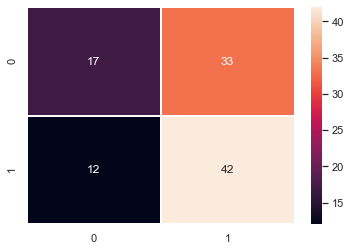

In [210]:
cf_matrix = confusion_matrix(y_test, y_pred_ab)
plt.figure(figsize = (6,4))
sns.heatmap(cf_matrix, linewidths=1, annot=True, fmt='g')
plt.show()

In [211]:
print(classification_report(y_test, y_pred_ab))

              precision    recall  f1-score   support

           0       0.59      0.34      0.43        50
           1       0.56      0.78      0.65        54

    accuracy                           0.57       104
   macro avg       0.57      0.56      0.54       104
weighted avg       0.57      0.57      0.55       104



### Bagging Classifier

In [212]:
from sklearn.ensemble import BaggingClassifier

In [213]:
bgcl = BaggingClassifier(random_state=473)

In [216]:
#BaggingClassifier?

In [214]:
bgcl.get_params().keys()

dict_keys(['base_estimator', 'bootstrap', 'bootstrap_features', 'max_features', 'max_samples', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [217]:
params={'max_samples': [0.1, 0.3, 0.7],
       'n_estimators':[50, 100, 200],
        'bootstrap':[True, False],
       'warm_start':[True, False]}

In [218]:
grid = GridSearchCV(bgcl, params, scoring='accuracy', cv=3, verbose=0)
grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

{'bootstrap': True, 'max_samples': 0.7, 'n_estimators': 200, 'warm_start': True}
0.5616559117035157


In [219]:
y_pred_bg = grid.predict(X_test)

print("Testing accuracies: ",round(grid.score(X_test, y_test),3))
print()
print("Recalls: ", round(recall_score(y_test, y_pred_bg),3))
print()
print("F1 Scores: ", round(f1_score(y_test, y_pred_bg),3))

Testing accuracies:  0.587

Recalls:  0.556

F1 Scores:  0.583


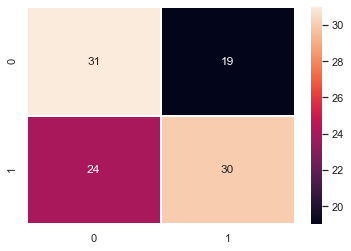

In [220]:
cf_matrix = confusion_matrix(y_test, y_pred_bg)
plt.figure(figsize = (6,4))
sns.heatmap(cf_matrix, linewidths=1, annot=True, fmt='g')
plt.show()

In [221]:
print(classification_report(y_test, y_pred_bg))

              precision    recall  f1-score   support

           0       0.56      0.62      0.59        50
           1       0.61      0.56      0.58        54

    accuracy                           0.59       104
   macro avg       0.59      0.59      0.59       104
weighted avg       0.59      0.59      0.59       104



### Grsdient Boosting Classifier

In [222]:
from sklearn.ensemble import GradientBoostingClassifier

In [223]:
gbcl = GradientBoostingClassifier(random_state=473)

In [225]:
#GradientBoostingClassifier?

In [224]:
gbcl.get_params().keys()

dict_keys(['ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'presort', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [237]:
params={'criterion':['friedman_mse', 'mse', 'mae'],
       'max_depth': [3, 5, 7],
       'learning_rate': [0.02, 0.05, 0.1],
        'min_impurity_decrease':[0.01, 0.1],
        'n_estimators':[50, 100],
        'subsample':[0.3, 0.5, 1],
       'warm_start':[True, False]}

In [238]:
grid = GridSearchCV(gbcl, params, scoring='accuracy', cv=3, verbose=0)
grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

{'criterion': 'mse', 'learning_rate': 0.05, 'max_depth': 3, 'min_impurity_decrease': 0.01, 'n_estimators': 50, 'subsample': 0.5, 'warm_start': True}
0.5835713530096266


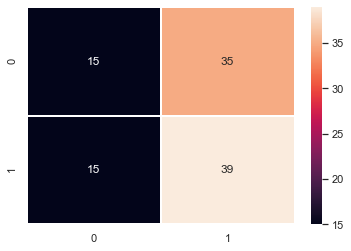

In [239]:
y_pred_gb = grid.predict(X_test)

cf_matrix = confusion_matrix(y_test, y_pred_gb)
plt.figure(figsize = (6,4))
sns.heatmap(cf_matrix, linewidths=1, annot=True, fmt='g')
plt.show()

In [240]:
print(classification_report(y_test, y_pred_gb))

              precision    recall  f1-score   support

           0       0.50      0.30      0.37        50
           1       0.53      0.72      0.61        54

    accuracy                           0.52       104
   macro avg       0.51      0.51      0.49       104
weighted avg       0.51      0.52      0.50       104



### Visualization of the best model feature importances

In [241]:
# Feature Importance
# features=[col for col in X.columns]

# importances = gbr_rs_model.feature_importances_
# indices = np.argsort(importances)

# plt.figure(figsize=(6,4))
# plt.title('Feature Importances')
# plt.barh(range(len(indices)), importances[indices], color='indianred', align='center')
# plt.yticks(range(len(indices)), [features[i] for i in indices])
# plt.xlabel('Relative Importance')

# plt.tight_layout()
# plt.savefig("output/final_model_features_importance.png")
# plt.show()


In [244]:
#predicted_unscaled_test=y_scaler.inverse_transform(y_pred_gbr.reshape(-1,1))
#predicted_unscaled_test

In [243]:
# from sklearn.linear_model import LinearRegression

# fig, ax = plt.subplots(figsize=(8,6))

# ax.scatter(y_test, predicted_unscaled_test, color='orange')

# ax.set_xlabel('Actual Strength (MPa)', fontsize=15)
# ax.set_ylabel('Predicted Strength (MPa)', fontsize=15)

# # #regression line
# lin_model = LinearRegression().fit(y_test.values.reshape(-1,1), predicted_unscaled_test)
# model_score = lin_model.score(y_test.values.reshape(-1,1), predicted_unscaled_test)

# ax.plot(y_test, lin_model.predict(y_test.values.reshape(-1,1)), color='green')

# ax.annotate(f'R2 (fit coeff.) = {round(model_score, 3)}', (5, 78), fontsize=16)

# plt.grid(True)

# plt.savefig("output/final_model_score.png")
# plt.show()



### Insights:

 - XXX.

## Conculsions